# Estimating wildlife damage to crops using crop insurance data
---

In [1]:
# Clean existing variables
rm(list=ls())
library(plyr)
library(tidyr)
library(dplyr)
library(reshape2)
library(frm)
library(httr)
library(lmtest)
library(sandwich)
library(broom)
library(margins)
library(ggplot2)
library(RColorBrewer)
library(mapproj)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: maps


Attaching package: ‘maps’


The following object is masked from ‘package:plyr’:

    ozone




---
### 1. Download data

TODO: Add some explanation of where the data comes from (url etc.)

In [2]:
getRMA <- function(type, years) {
  # This function downloads individual yearly policy or claim files from the RMA website.  
  # Args:
  #   type: The type of file, must be "policy" or "claim"
  #   years: A vector of integer years. Data from from multiple years will be horizontally stacked
  # Return:
  #   A dataframe
    
  if (type == 'policy') {
      base_url <- "https://www.rma.usda.gov/-/media/RMAweb/SCC-SOB/State-County-Crop-Coverage/sobcov_"
  } else if (type == 'claim') {
      base_url <- "https://www.rma.usda.gov/-/media/RMAweb/Cause-Of-Loss/Summary-of-Business-with-Month-of-Loss/colsom_"
  } else {
      stop("type must equal 'policy' or 'claim'")
  }
    
  # store df from each year in a list
  df_list <- list()
  for (y in 1:length(years)) {
    response <- GET(paste0(base_url, years[y], ".ashx?la=en"))
    writeBin(content(response, as = "raw"), "temp.zip")
    fName <- unzip("temp.zip", list = TRUE)$Name
    unzip("temp.zip")
    df <- read.table(fName, sep = "|", header = FALSE, dec =".", quote = "", 
                     fill=TRUE, skipNul=TRUE, strip.white=TRUE)
    file.remove(c("temp.zip", fName))
    df_list[[y]] <- df  
  }
    
  # vertically concat the list of dataframes
  data <- do.call("rbind", df_list)
    
  return(data)
}


getTypes <- function(df) {
    types = c()
    for (col in colnames(df)) {
        types <- c(types, class(df[, col]))
    }
    return(types)
}


# TODO: The code in this function is will fail silently. Where do these cols come from?
renameCols <- function(df) {
    # Inserts real col names.
    # Args:
    #   df: The dataframe that needs col names
    # Return:
    #   The dataframe with new col names
    
    if (dim(df)[2] != 28 & dim(df)[2] != 30) {
        stop('The dataframe does not have the expected number of columns. Please check for changes in the structure
              of the datafiles.')
    }
    
    if (dim(df)[2] == 28) {
        types <- getTypes(df)
        policy_types = c(
            'integer', 'integer', 'factor', 'integer', 'factor', 'integer', 'factor', 'integer', 'factor', 'factor', 'factor',
            'numeric', 'integer', 'integer', 'integer', 'integer', 'integer', 'factor', 'integer', 'integer', 'integer',
            'integer', 'integer', 'integer', 'integer', 'integer', 'integer', 'numeric'
        )
        if (!identical(types, policy_types)) {
            stop('The datatypes of the cols do not match expectations. Please check for changes in the structure
                  of the datafiles.')
        }
    }
    
    if (dim(df)[2] == 30) {
        types <- getTypes(df)
        
        claims_types = c(
            'integer', 'integer', 'factor', 'integer', 'factor', 'integer', 'factor', 'integer', 'factor', 
            'factor', 'factor' ,'factor', 'factor', 'integer', 'factor', 'integer', 'integer', 'integer', 
            'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 
            'numeric', 'numeric', 'numeric'
        )
        if (!identical(types, claims_types)) {
            stop('The datatypes of the cols do not match expectations. Please check for changes in the structure
                  of the datafiles.')
        }
    }
    
    if (dim(df)[2] == 28) {
      cols <- cols <- c("year", "stfips", "stabb", "cntyfips", "cntyname", "commoditycode", "commodityname", 
                        "insplancode","insplanname", "covcateg", "delivtype", "covlevel", "polsold", "polprem", 
                        "polindemn", "unitssold", "unitsindemn", "quanttype", "acres", "endorsedacres",  
                        "liab", "totalpremium", "subsidies", "stateprivsubsity", "addsubsidy", "efadisc",
                        "indemnityamount", "lossratio")
    }
    if (dim(df)[2] == 30) {
      cols <- cols  <- c("year", "stfips", "stabb", "cntyfips", "cntyname", "commoditycode", "commodityname", 
                         "insplancode","insplanname", "covcateg", "stagecode", "damagecausecode", "damagecausedesc", 
                         "monthloss", "monthname", "yearloss", "polprem", "polindemn",  "acres", "endorsedacres",  
                         "liab", "totalpremium", "producerpremuim", "subsidies", "stateprivatesubs", "addsubs", 
                         "EFApremdiscount", "lostacres", "indemnityamount", "lossratio")
    }
    names(df) <- cols
    return(df)
}

#### Download policy files

In [3]:
full_polacres <- getRMA(type='policy', years=c(2017, 2018))
full_polacres <- renameCols(df=full_polacres)
print(dim(full_polacres))

[1] 268114     28


#### Download claim files

In [4]:
claims <- getRMA(type='claim', years=c(2017, 2018))
claims <- renameCols(df=claims)
print(dim(claims))

[1] 244660     30


---
### 2. Data organization

TODO: add some explanation. There is a figure in the paper we can embed here.

In [5]:
sumCov <- function(df, variable, w=0) {
  sub_df <- df[, grepl(variable, names(df))]
  names(sub_df) <- suppressWarnings(as.numeric(sub(paste(variable, ".", sep = ""), "", names(sub_df))))
  sub_df[, is.na(names(sub_df))] <- NULL
  ifelse(w == 0,
        return(rowSums(sub_df)),
        return(rowSums(as.matrix(sub_df) %*% diag(names(sub_df)))))
}

In [6]:
format_policies <- function(df) {
  # TODO: add docstring
  df <- reshape(df, idvar = c("year", "stfips", "stabb", "cntyfips", "cntyname", 
                              "commoditycode", "commodityname", "insplancode", 
                              "insplanname", "covcateg", "claim"), 
                timevar = "covlevel", v.names=c("acres", "unitssold"), direction = "wide")
  df[is.na(df)] <- 0
  # calculate the mean coverage level and the number of units sold by year, stfips, 
  # cntyfips, commoditycode, insplancode, covcateg, claim combination
  df$acres.total <- sumCov(df, "acres") 
  df$unitssold <- sumCov(df, "unitssold")
  df$meancov <- sumCov(df, "acres", w=1) / df$acres.total
  myvars <- c("year","stfips", "stabb", "cntyfips", "cntyname", "commoditycode", "commodityname", 
              "insplancode", "insplanname", "covcateg", "claim", "acres.total", "unitssold", "meancov")
  df <- df[myvars]
  
  return(df)
}

In [7]:
split_polacres <- function(full_polacres) {
    # only keep policies with premium expressed in acres and known county fips and commodity code
    polacres <- full_polacres[full_polacres$polprem > 0 & 
                              full_polacres$quanttype == "Acres" & full_polacres$acres > 0 & 
                              full_polacres$commoditycode != 9999, ]
    polacres$claim <- ifelse(polacres$unitsindemn > 0, 1, 0)
    myvars <- c("year", "stfips", "stabb", "cntyfips", "cntyname", "commoditycode", "commodityname", 
                "insplancode", "insplanname", "covcateg", "covlevel", "unitssold", "claim", "acres")
    polacres <- polacres[myvars]
    polacres <- format_policies(polacres)

    # we split the policy file into polacresclaim for which we have claims
    polacresclaim <- polacres[polacres$claim == 1, ]
    # and polacresnoclaim for which we have no claims. We save this file for later.
    polacresnoclaim <- polacres[polacres$claim == 0, ]
    polacresnoclaim$lostacres <- 0
    
    return(list(polacresclaim, polacresnoclaim))
}

In [8]:
join_claims_data <- function(claims, polacresclaim) {
    # only keep wildlife claims with insured and lost acres and known county fips and commodity code
    claimswild <- claims[claims$cntyfips < 999 & claims$acres > 0 & 
                         claims$commoditycode != 9999 & claims$lostacres > 0 & claims$damagecausecode == 93, ]

    claimswild <- aggregate(cbind(lostacres) ~ year + stfips + stabb + cntyfips + cntyname + commoditycode + 
                            commodityname + insplancode + insplanname + covcateg, 
                            data = claimswild, FUN = function(x) sum(x), na.action=NULL )

    claimspol <- join(polacresclaim, claimswild, by=c("year", "stfips", "stabb", "cntyfips", "cntyname", 
                                                      "commoditycode", "commodityname", "insplancode", 
                                                      "insplanname", "covcateg"), type='left')

    return(claimspol)
}

In [9]:
build_features <- function(claimspol, polacresnoclaim) {
    # we can now append the 2 files
    claimpoltot <- bind_rows(claimspol, polacresnoclaim)
    claimpoltot$lostacres[is.na(claimpoltot$lostacres)] <- 0
    claimpoltot$ratio <- claimpoltot$lostacres/claimpoltot$acres.total
    claimpoltot$ratio[claimpoltot$ratio > 1] <- 1
    claimpoltot$lostacres <- claimpoltot$ratio*claimpoltot$acres
    claimpoltot$fullfips <- claimpoltot$stfips*1000 + claimpoltot$cntyfips
    claimpoltot$logacres <- log(claimpoltot$acres.total)
    claimpoltot$logunitssold <- log(claimpoltot$unitssold)
    claimpoltot$cat <- ifelse(claimpoltot$covcateg=="C", 1, 0)
    claimpoltot$y2017 <- ifelse(claimpoltot$year==2017, 1, 0)

    # create string variables to be treated as categorical variables
    claimpoltot$fullfips.ch <- as.character(claimpoltot$fullfips)
    claimpoltot$commoditycode.ch <- as.character(claimpoltot$commoditycode)
    claimpoltot$insplancode.ch <- as.character(claimpoltot$insplancode)

    return(claimpoltot)
}

In [10]:
split <- split_polacres(full_polacres)
polacresclaim <- split[[1]]
polacresnoclaim <- split[[2]]

claimspol <- join_claims_data(claims, polacresclaim)

claimpoltot <- build_features(claimspol, polacresnoclaim)

---
### 3. Modeling

In [11]:
model_glm = glm(
  ratio ~  meancov + logacres + logunitssold + cat + y2017 + insplancode.ch + commoditycode.ch + fullfips.ch,
  epsilon = 1e-6,
  data = claimpoltot,
  family = quasibinomial
)

# get robust standard errors
tidy(coeftest(model_glm, vcov = vcovHC(model_glm, type="HC")))

summary(model_glm)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-16.7585937,1.99459308,-8.4020114,4.388954e-17
meancov,5.0470802,0.79920226,6.3151476,2.699038e-10
logacres,-0.5818458,0.06689616,-8.6977455,3.385428e-18
logunitssold,0.5429134,0.08861402,6.1267207,8.970874e-10
cat,-0.7797529,0.34366727,-2.2689181,2.327331e-02
y2017,0.1276205,0.09471042,1.3474807,1.778255e-01
insplancode.ch13,-4.6971582,1.89504314,-2.4786550,1.318788e-02
insplancode.ch16,-12.5535247,0.72720395,-17.2627290,8.976638e-67
insplancode.ch17,-13.2290241,0.72143081,-18.3372042,4.177351e-75



Call:
glm(formula = ratio ~ meancov + logacres + logunitssold + cat + 
    y2017 + insplancode.ch + commoditycode.ch + fullfips.ch, 
    family = quasibinomial, data = claimpoltot, epsilon = 1e-06)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.97934  -0.01761  -0.00023  -0.00004   3.03552  

Coefficients: (5 not defined because of singularities)
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -1.676e+01  3.534e+02  -0.047 0.962176    
meancov               5.047e+00  2.364e-01  21.352  < 2e-16 ***
logacres             -5.818e-01  1.913e-02 -30.411  < 2e-16 ***
logunitssold          5.429e-01  2.461e-02  22.057  < 2e-16 ***
cat                  -7.798e-01  9.300e-02  -8.384  < 2e-16 ***
y2017                 1.276e-01  2.996e-02   4.260 2.04e-05 ***
insplancode.ch13     -4.697e+00  3.548e+02  -0.013 0.989438    
insplancode.ch16     -1.255e+01  2.705e+02  -0.046 0.962985    
insplancode.ch17     -1.323e+01  9.249e+01  -

---
### 4. Results

In [12]:
# Estimated lost acres if no low coverage
data <- claimpoltot[claimpoltot$year == 2018, ]
data$meancov <- 1  # 100%
data$insplancode.ch <- "1"
data$cat <- 0
data$preds <- predict(model_glm, data, se.fit = FALSE, type = "response")

summary(data$preds)

data$lostacres.hat <- data$acres.total * data$preds
data <- aggregate(cbind(acres.total, lostacres, lostacres.hat) ~ year + fullfips + stfips + stabb + cntyfips + 
                                                                 cntyname + commoditycode + commodityname, 
                   data = data, FUN = function(x) sum(x), na.action=NULL )

data$ratio.county <- data$lostacres / data$acres.total
data$ratio.county.hat <- data$lostacres.hat / data$acres.total
summary(data$ratio.county)
summary(data$ratio.county.hat)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000134 0.0125276 0.0022282 0.9343842 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.00252 0.00000 1.00000 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000008 0.0120880 0.0016072 0.9343842 

In [21]:
install.packages('knitr')

Installing package into ‘/usr/local/lib/R/3.6/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘highr’, ‘markdown’, ‘xfun’




In [22]:
library('ggplot2')
library('RColorBrewer')
library('scales')
devtools::install_github('anderaa/quickerstats', force=TRUE, build_vignettes=TRUE, ref='master')
library('quickerstats')


✔  checking for file ‘/private/var/folders/pb/s52njbv11sl00c5b_xd40rw40000gn/T/RtmppzWUJg/remotesfa5142f987f3/anderaa-quickerstats-5aa3434/DESCRIPTION’
─  preparing ‘quickerstats’:
✔  checking DESCRIPTION meta-information
─  installing the package to build vignettes
✔  creating vignettes (1.1s)
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘quickerstats_0.0.0.9007.tar.gz’
   


Installing package into ‘/usr/local/lib/R/3.6/site-library’
(as ‘lib’ is unspecified)



In [23]:
key = Sys.getenv('NASS_KEY')

In [ ]:
get_ratio_map_data <- function(crop_list, county_shape_path, state_shape_path, ratio_path) {
  # This function return state and county shape files needed to produce ratio maps
  # Args:
  #   crop_list: A list containing lists of crop and crop-code pairs for targeted crops.
  #   county_shape_path: Relative path to county shape file.
  #   state_shape_path: Relative path to state shape file.
  #   ratio_path: Relative path to data containing estimate ratios
  # Returns: A list containing county and state shape files
  
  # load data 
  county <- read.csv(county_shape_path)
  state <- read.csv(state_shape_path)
  data <- read.csv(ratio_path, stringsAsFactors = FALSE)
  
  # organize loss data
  county$Fips = as.character(county$Fips)
  data$cntyfips <- as.character(data$cntyfips)
  data$stfips <- as.character(data$stfips)
  data$fips <- NA
  
  # fix problem with leading zeros in fips strings
  for (i in 1:nrow(data)) {
    if (nchar(data$cntyfips[i]) == 1) {
      data$cntyfips[i] = paste('00', data$cntyfips[i], sep='')
    }
    if (nchar(data$cntyfips[i]) == 2) {
      data$cntyfips[i] = paste('0', data$cntyfips[i], sep='')
    }
    data$fips[i] = paste(data$stfips[i], data$cntyfips[i], sep='')
  }
  
  # loop through crops and add to dataframe of data for map
  for (i in 1:length(crop_list)) {
    county[crop_list[[i]][[1]]] <- NA
    for (j in 1:nrow(data)) {
      if (data$commoditycode[j] == crop_list[[i]][[2]]) {
        county[county$Fips == data$fips[j], crop_list[[i]][[1]]] = data$ratiohat[j]
      }
    }
  }
  
  return(list(county, state))
}


plot_fraction_lost <- function(crop) {
  # plot fraction of acres lost for every county in US
  
  crop <- tolower(crop)
  county_data[crop]
  ggplot() + 
    theme_void() +
    theme(legend.position="bottom") +
    theme(legend.text=element_text(size=12)) +
    theme(legend.key.width=unit(2,"cm")) +
    theme(axis.title=element_blank(),
          plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    #ggtitle(paste('Percent of', tools::toTitleCase(crop),  'Acres Lost to Wildlife')) + 
    scale_fill_gradientn('', colours = brewer.pal(9, 'YlOrRd'), 
                         limits=c(0, 0.10),
                         breaks=c(0, 0.05, 0.10),
                         oob=squish,
                         labels=c('0%', '5%', '>10%')) +
    
    #scale_fill_gradientn('', colours = brewer.pal(9, 'YlOrRd')) +
    # county polygons 
    geom_polygon(data = county_data[order(county_data$order), ],
                 aes_string('long', 'lat', group = 'group', fill = crop),
                 col = "#c0c5ce", size=0.1) +
    # cords
    coord_map("bonne",  param = 40) + 
    # state polygons
    geom_polygon(data = state_data[ order(state_data$state_order), ],
                 aes(state_long, state_lat, group = state_group),
                 fill = NA,
                 col = "black")
}

In [ ]:
# assemble args for ratio data function
county_shape_path <- 'data/county_shape.csv'
state_shape_path <- 'data/state_shape.csv'
ratio_path <- 'data/predictions_ratio_allfips_1_cov.csv'
crop_list <- list(list('corn', 41), list('wheat', 11), list('soybeans', 81), list('cotton', 21))

# get ratio data for mapping
map_data <- get_ratio_map_data(crop_list, county_shape_path, state_shape_path, ratio_path)
county_data <- map_data[[1]]
state_data <- map_data[[2]]


# add zero to fips codes to ease merging with nass data
for (i in 1:nrow(county_data)) {
  if (nchar(county_data$Fips[i]) == 4) {
    county_data$Fips[i] = paste('0', county_data$Fips[i], sep='')
  }
}


merge_sales <- function(map_data, data_item, col_name) {
  # This function add revenue columns to the county mapping data
  crop_data <- get_county_data(key, 2017, data_item)
  crop_data <- within(crop_data, fips <- paste(state_fips_code, 
                                               county_code,sep=''))
  crop_data['fips']
  crop_data['Value']
  map_data[col_name] <- 0
  for (i in 1:nrow(crop_data)) {
    fips <- as.character(crop_data[i, 'fips'])
    value <- crop_data[i, 'Value']
    if (value == '(D)') {
      value = NA
    } else {
      value = gsub(',', '', value)
      value = as.numeric(value)
    }
    map_data[map_data$Fips == fips, col_name] <- value
  }
  return(map_data)
}  

# merge sales data into mapping data
county_data <- merge_sales(county_data, "CORN - SALES, MEASURED IN $", 'corn_revenue')
county_data <- merge_sales(county_data, "WHEAT - SALES, MEASURED IN $", 'wheat_revenue')
county_data <- merge_sales(county_data, "SOYBEANS - SALES, MEASURED IN $", 'soybeans_revenue')
county_data <- merge_sales(county_data, "COTTON, LINT & SEED - SALES, MEASURED IN $", 'cotton_revenue')

# get maps
corn <- plot_fraction_lost('corn')
ggsave('corn_fraction.svg', plot=corn, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')
soybeans <- plot_fraction_lost('soybeans')
ggsave('soybeans_fraction.svg', plot=soybeans, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')
wheat <- plot_fraction_lost('wheat')
ggsave('wheat_fraction.svg', plot=wheat, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')
cotton <- plot_fraction_lost('cotton')
ggsave('cotton_fraction.svg', plot=cotton, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')


plot_sales <- function(crop) {
  crop <- tolower(crop)
  col_name <- paste(crop, '_revenue', sep='')
  ggplot() + 
    theme_void() +
    theme(legend.position="bottom") +
    theme(legend.key.width=unit(2,"cm")) +
    theme(legend.text=element_text(size=12)) +
    theme(axis.title=element_blank(),
          plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    scale_fill_gradientn('', colours = brewer.pal(9, 'YlOrRd'), 
                         limits=c(0, 100000000),
                         breaks=c(0, 50000000, 100000000),
                         oob=squish,
                         labels=c('$0', '$50mil', '>$100mil')) +
    # county polygons 
    geom_polygon(data = county_data[order(county_data$order), ],
                 aes_string('long', 'lat', group = 'group', fill = col_name),
                 col = "#c0c5ce", size=0.1) +
    # cords
    coord_map("bonne",  param = 40) + 
    # state polygons
    geom_polygon(data = state_data[ order(state_data$state_order), ],
                 aes(state_long, state_lat, group = state_group),
                 fill = NA,
                 col = "black") 
}


# make plots of sales data
corn_sales_plot <- plot_sales('corn')
ggsave('corn_sales_plot.svg', plot=corn_sales_plot, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')

soybean_sales_plot <- plot_sales('soybeans')
ggsave('soybean_sales_plot.svg', plot=soybean_sales_plot, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')

wheat_sales_plot <- plot_sales('wheat')
ggsave('wheat_sales_plot.svg', plot=wheat_sales_plot, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')

cotton_sales_plot <- plot_sales('cotton')
ggsave('cotton_sales_plot.svg', plot=cotton_sales_plot, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')


# calculate dollar losses
county_data$corn_loss <- (county_data$corn_revenue / (1 - county_data$corn)) - county_data$corn_revenue
county_data$wheat_loss <- (county_data$wheat_revenue / (1 - county_data$wheat)) - county_data$wheat_revenue
county_data$soybeans_loss <- (county_data$soybeans_revenue / (1 - county_data$soybeans)) - county_data$soybeans_revenue
county_data$cotton_loss <- (county_data$cotton_revenue / (1 - county_data$cotton)) - county_data$cotton_revenue


plot_loss_dollars <- function(crop) {
  crop <- tolower(crop)
  col_name <- paste(crop, '_loss', sep='')
  ggplot() + 
    theme_void() +
    theme(legend.position="bottom") +
    theme(legend.key.width=unit(2,"cm")) +
    theme(legend.text=element_text(size=12)) +
    theme(axis.title=element_blank(),
          plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    scale_fill_gradientn('', colours = brewer.pal(9, 'YlOrRd'), 
                         limits=c(0, 500000),
                         breaks=c(0, 250000, 500000),
                         oob=squish,
                         labels=c('$0', '$250k', '>$500k')) +
    
    # scale_fill_gradientn('', colours = brewer.pal(9, 'YlOrRd')) +
    # county polygons 
    geom_polygon(data = county_data[order(county_data$order), ],
                 aes_string('long', 'lat', group = 'group', fill = col_name),
                 col = "#c0c5ce", size=0.1) +
    # cords
    coord_map("bonne",  param = 40) + 
    # state polygons
    geom_polygon(data = state_data[ order(state_data$state_order), ],
                 aes(state_long, state_lat, group = state_group),
                 fill = NA,
                 col = "black") 
}


corn_loss_plot <- plot_loss_dollars('corn')
ggsave('corn_county_loss.svg', plot=corn_loss_plot, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')
soybean_loss_plot <- plot_loss_dollars('soybeans')
ggsave('soybean_county_loss.svg', plot=soybean_loss_plot, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')
wheat_loss_plot <- plot_loss_dollars('wheat')
ggsave('wheat_county_loss.svg', plot=wheat_loss_plot, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')
cotton_loss_plot <- plot_loss_dollars('cotton')
ggsave('cotton_county_loss.svg', plot=cotton_loss_plot, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')


# get state sum data
summary_data <- county_data
summary_data <- summary_data[!duplicated(summary_data$Fips), ]
state_fips <- unique(summary_data$state_fips)
for (state in state_fips) {
  
  corn_loss <- sum(summary_data[summary_data$state_fips == state, 'corn_loss'], na.rm=T)
  state_data[state_data$state_fips == state, 'corn_loss'] <- corn_loss
  
  soybeans_loss <- sum(summary_data[summary_data$state_fips == state, 'soybeans_loss'], na.rm=T)
  state_data[state_data$state_fips == state, 'soybeans_loss'] <- soybeans_loss
  
  wheat_loss <- sum(summary_data[summary_data$state_fips == state, 'wheat_loss'], na.rm=T)
  state_data[state_data$state_fips == state, 'wheat_loss'] <- wheat_loss
  
  cotton_loss <- sum(summary_data[summary_data$state_fips == state, 'cotton_loss'], na.rm=T)
  state_data[state_data$state_fips == state, 'cotton_loss'] <- cotton_loss
  
}

plot_state_loss <- function(series) {
  ggplot() + 
    theme_void() +
    theme(legend.position="bottom") +
    theme(legend.key.width=unit(2,"cm")) +
    theme(legend.text=element_text(size=12)) +
    theme(axis.title=element_blank(),
          plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    scale_fill_gradientn('', colours = brewer.pal(9, 'YlOrRd'), 
                         limits=c(0, 40000000),
                         breaks=c(0,20000000, 40000000),
                         oob=squish,
                         labels=c('$0', '20mil', '>$40mil')) +
    
    # scale_fill_gradientn('', colours = brewer.pal(9, 'YlOrRd')) +
    # county polygons 
    geom_polygon(data = state_data[order(state_data$state_order), ],
                 aes_string('state_long', 'state_lat', group = 'state_group', 
                            fill = series),
                 col = "#c0c5ce", size=0.1) +
    # cords
    coord_map("bonne",  param = 40) 
}

state_corn_plot <- plot_state_loss('corn_loss')
ggsave('state_corn_plot.svg', plot=state_corn_plot, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')
state_soybeans_plot <- plot_state_loss('soybeans_loss')
ggsave('state_soybeans_plot.svg', plot=state_soybeans_plot, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')
state_wheat_plot <- plot_state_loss('wheat_loss')
ggsave('state_wheat_plot.svg', plot=state_wheat_plot, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')
state_cotton_plot <- plot_state_loss('cotton_loss')
ggsave('state_cotton_plot.svg', plot=state_cotton_plot, device='svg', path=NULL,
       scale=1, width=10, height=7, dpi=320, units='in')


state_summary_data <- state_data[!duplicated(state_data$state_fips), ]
dim(state_summary_data)
write.csv(state_summary_data, 'state_summary.csv')

sum(state_summary_data['corn_loss'], na.rm=T)
sum(state_summary_data['soybeans_loss'], na.rm=T)
sum(state_summary_data['wheat_loss'], na.rm=T)
sum(state_summary_data['cotton_loss'], na.rm=T)

# cotton_data <- get_county_data(key, 2017, 'COTTON - PRODUCTION, MEASURED IN BALES')
# corn_data <- get_county_data(key, 2017, 'CORN, GRAIN - PRODUCTION, MEASURED IN BU')
# soybean_data <- get_county_data(key, 2017, 'SOYBEANS - PRODUCTION, MEASURED IN BU')
# wheat_data <- get_county_data(key, 2017, 'WHEAT - PRODUCTION, MEASURED IN BU')



In [13]:
# load data 
cty_shape <- read.csv("data/county_shape.csv")
st_shape <- read.csv("data/state_shape.csv")

# organize loss data
cty_shape$Fips = as.character(cty_shape$Fips)
data$cntyfips <- as.character(data$cntyfips)
data$stfips <- as.character(data$stfips)
data$fips <- NA

# fill in the combined (4 or 5 digit) fips in data
for (i in 1:nrow(data)) {
  if (nchar(data$cntyfips[i]) == 1) {
    data$cntyfips[i] = paste('00', data$cntyfips[i], sep='')
  }
  if (nchar(data$cntyfips[i]) == 2) {
    data$cntyfips[i] = paste('0', data$cntyfips[i], sep='')
  }
  data$fips[i] = paste(data$stfips[i], data$cntyfips[i], sep='')
}

In [14]:
cty_shape['lost_corn'] <- NA
cty_shape['lost_wheat'] <- NA
cty_shape['lost_soybeans'] <- NA
cty_shape['lost_peanuts'] <- NA

for (i in 1:nrow(data)) {
  if (data$commoditycode[i] == 41) {
    cty_shape[cty_shape$Fips == data$fips[i], 'lost_corn'] = data$ratio.county.hat[i]
  }
  if (data$commoditycode[i] == 11) {
    cty_shape[cty_shape$Fips == data$fips[i], 'lost_wheat'] = data$ratio.county.hat[i]
  }
  if (data$commoditycode[i] == 81) {
    cty_shape[cty_shape$Fips == data$fips[i], 'lost_soybeans'] = data$ratio.county.hat[i]
  }
  if (data$commoditycode[i] == 75) {
    cty_shape[cty_shape$Fips == data$fips[i], 'lost_peanuts'] = data$ratio.county.hat[i]
  }
}

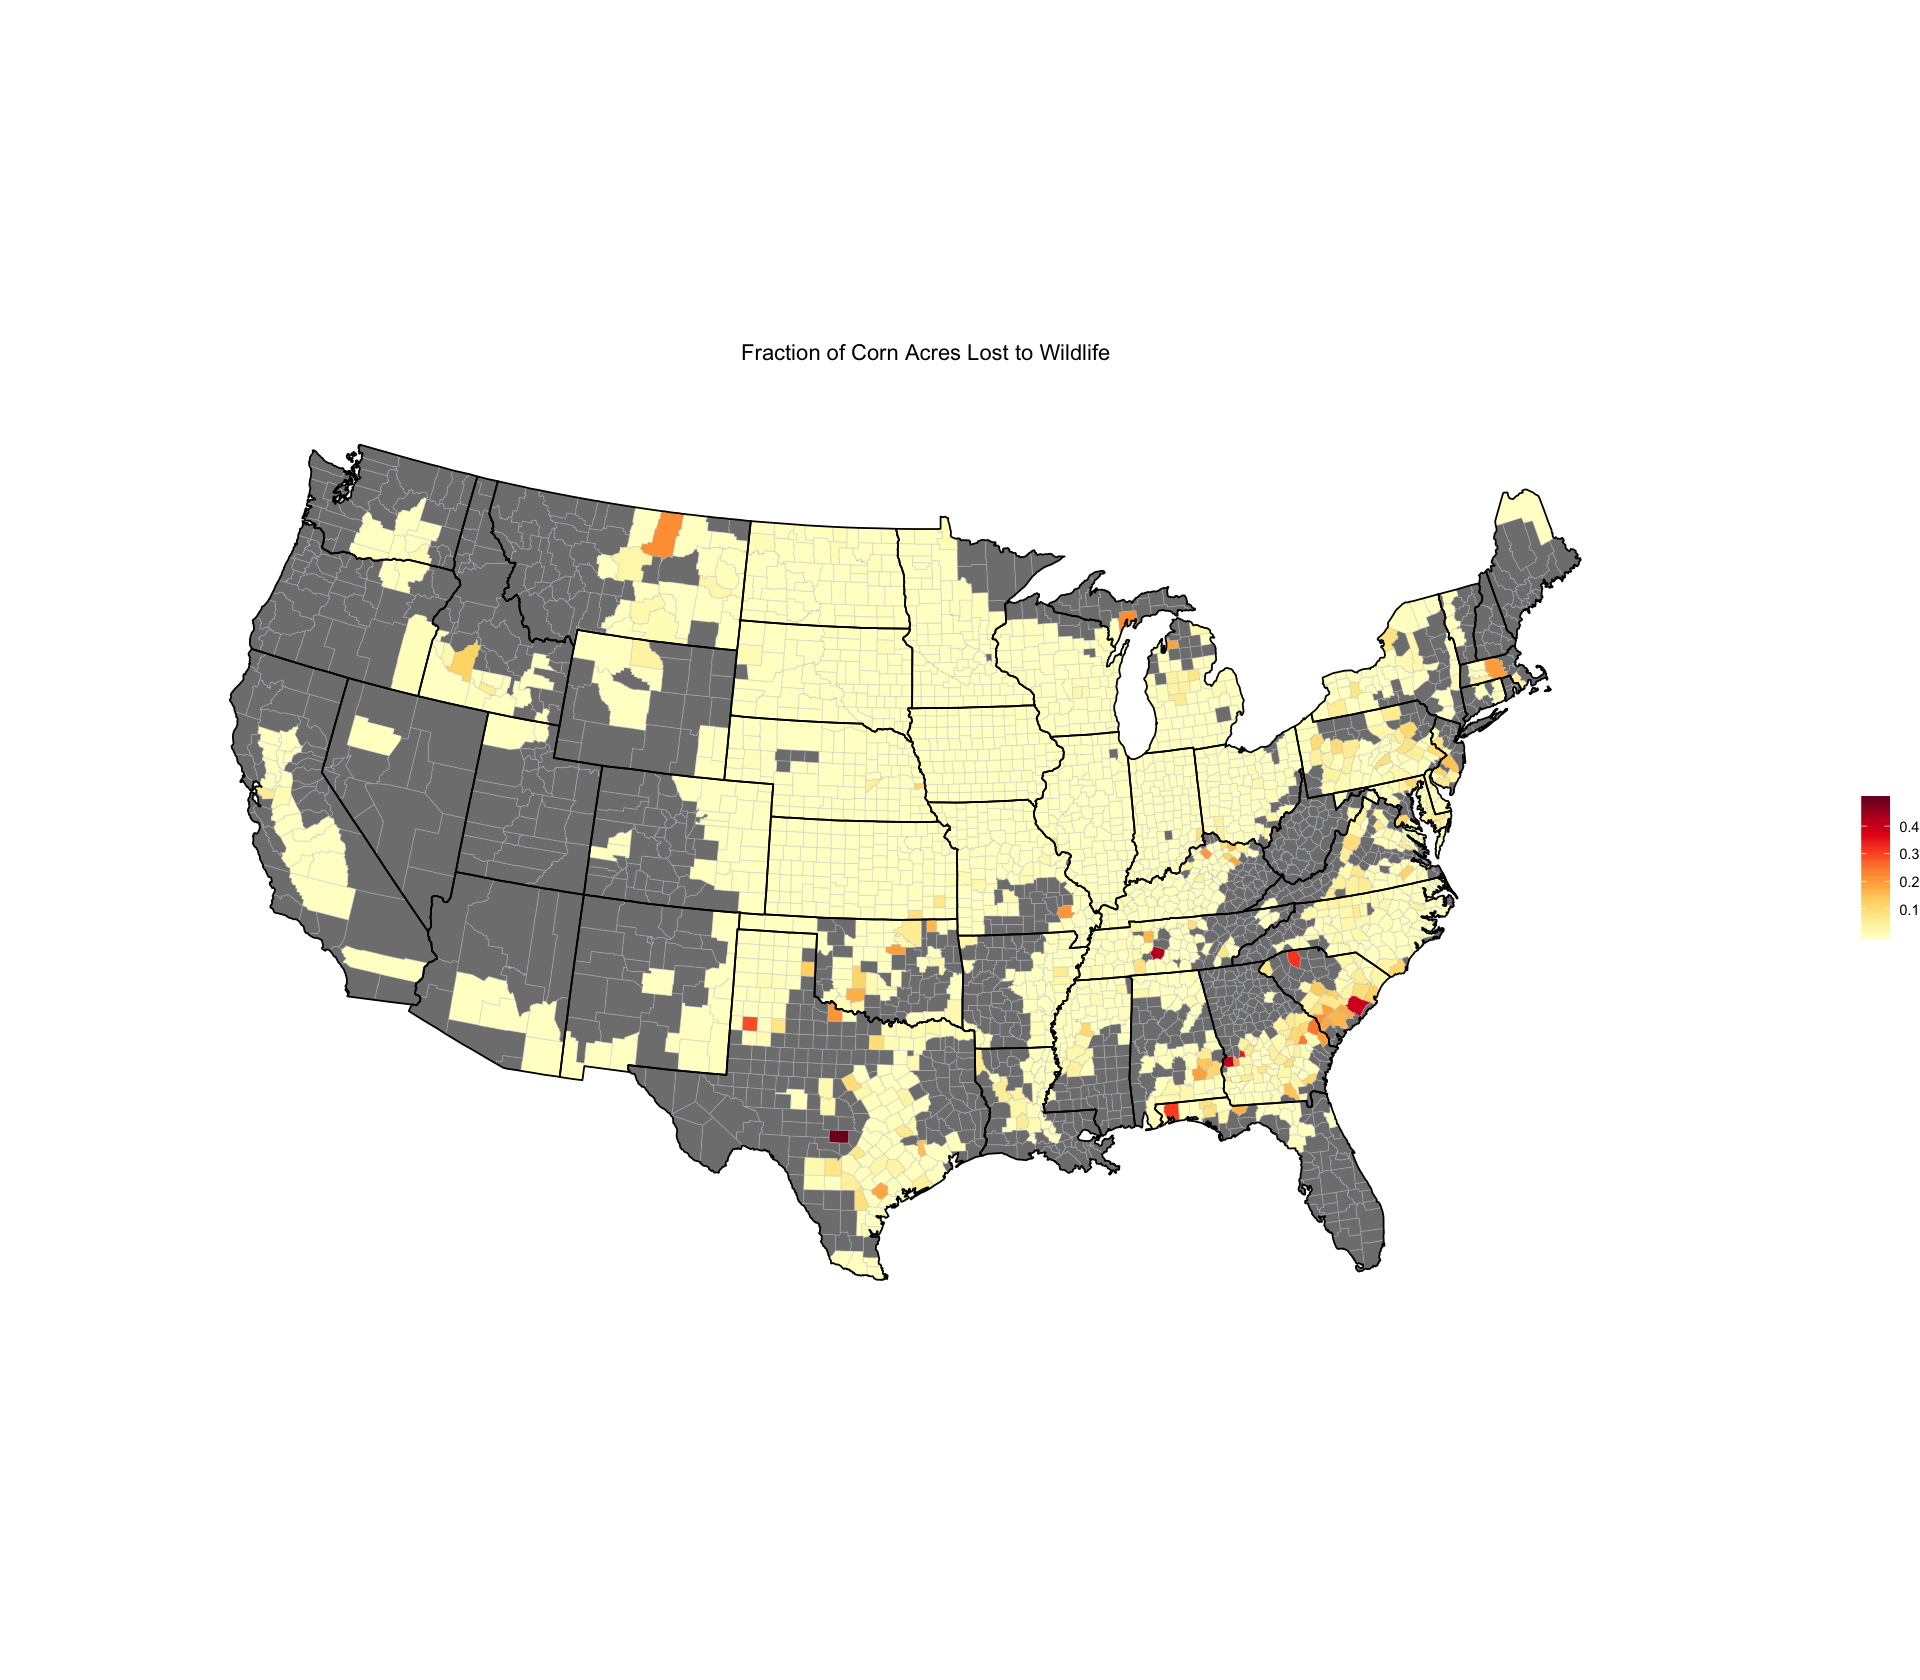

In [19]:
options(repr.plot.width=16, repr.plot.height=14)


# map it
ggplot() + 
  theme_void() +
  theme(plot.title = element_text(hjust = 0.5)) +
  ggtitle('Fraction of Corn Acres Lost to Wildlife') + 
  scale_fill_gradientn('', colours = brewer.pal(9, 'YlOrRd')) +
  # county polygons 
  geom_polygon(data = cty_shape[ order(cty_shape$order), ],
               aes(long, lat, group = group, fill = lost_corn),
               col = "#c0c5ce", size=0.1) +
  # cords
  coord_map("bonne",  param = 40) + 
  # state polygons
  geom_polygon(data = st_shape[ order(st_shape$state_order), ],
               aes(state_long, state_lat, group = state_group),
               fill = NA,
               col = "black")

In [ ]:
# map it
ggplot() + 
  theme_void() +
  theme(plot.title = element_text(hjust = 0.5)) +
  ggtitle('Fraction of Corn Acres Lost to Wildlife') + 
  scale_fill_gradientn('', colours = brewer.pal(9, 'YlOrRd')) +
  # county polygons 
  geom_polygon(data = cty_shape[ order(cty_shape$order), ],
               aes(long, lat, group = group, fill = lost_corn),
               col = "#c0c5ce", size=0.1) +
  # cords
  coord_map("bonne",  param = 40) + 
  # state polygons
  geom_polygon(data = st_shape[ order(st_shape$state_order), ],
               aes(state_long, state_lat, group = state_group),
               fill = NA,
               col = "black")